# Clutter Monitoring notebook

The Relative Calibration Adjusment technique (RCA) is a 2-step technique:
>- 1st step: Generate a clutter frequency map, at least on 1 day of data.
>- 2nd step: Extracting the change in calibration.

In [31]:
import os
import glob
import warnings
import traceback

from multiprocessing import Pool

import pyart
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

from numba import jit
from netCDF4 import num2date

warnings.simplefilter('ignore')

In [2]:
# Path to radar data (at least one day required)
INDIR = "/g/data2/rr5/vhl548/CPOL_level_1/2006/20060101/"
flist = glob.glob(os.path.join(INDIR, "*.nc"))

# Part 1: Generate clutter map

In [3]:
def azi2angl(azi):    
    """
    Convert azimuth angle to true angle (in degree).
    """
    h = 450 - azi
    h[h > 360] = h[h > 360] - 360
    return h

In [4]:
def get_clutter_position(radar, 
                         dbz_name = "DBZ", 
                         rhohv_name = "RHOHV", 
                         refl_thrld = 45, 
                         rhohv_thrld = 0.6, 
                         maxrange = 10e3):  
    """
    Get (range, azimuth) position of non meteorological echoes.
    
    Parameters:
    ===========
        radar: struct
            Py-ART radar structure.
        dbz_name: str
            Reflectivity field name.
        rhohv_name: str
            Cross-correlation field name.
        refl_thrld: float
            Minimum reflectivity threshold (in dBZ)
        rhohv_thrld: float
            Maximum cross correlation threshold below which echoes 
            are not from a meteorological source.
        maxrange: int
            Maximum range (in meters)
            
    Returns:
    ========
        r_clutter: np.array
            Range position of non-meteorological echoes.
        azi_clutter: np.array
            Azimuth position of non-meteorological echoes.    
    """
    # Extract first elevation only
    rslice = radar.get_slice(0)
    # Extract range/azimuth
    r = radar.range['data'].astype(int)
    azi = radar.azimuth['data'][rslice]
    # Check azimuth field.
    if len(azi) <= 60:
        print("Invalid azimuth field")
        return None
    
    # Get reflectivity and RHOHV
    total_power = radar.fields[dbz_name]['data'][rslice].filled(np.NaN)
    cross_correlation_ratio = radar.fields[rhohv_name]['data'][rslice].filled(np.NaN)
    
    # Removing every echoes that are above RHOHV threshold, below DBZ threshold and above maximum range.
    clut = total_power
    clut[(cross_correlation_ratio > rhohv_thrld) | (total_power < refl_thrld)] = np.NaN    
    clut[:, r > maxrange] = np.NaN
    
    # Position of remaining echoes
    posa, posr = np.where(~np.isnan(clut))
    
    r_clutter = r[posr]
    azi_clutter = azi[posa]    
    
    return r_clutter, azi_clutter

In [5]:
@jit(nopython=True)
def _jit_find_clut_pos(rrange, theta, range_list, azi_list):
    # Initializing frequency array
    frequency = np.zeros((len(theta), len(rrange)))
    # Running through lists of non-meteorological echoes
    for myr, mya in zip(range_list, azi_list):
        # Finding their positions
        apos = np.argmin(np.abs(theta - mya))
        rpos = np.argmin(np.abs(rrange - myr))

        frequency[apos, rpos] += 1
    return frequency

In [12]:
def compute_frequency_map(rrange, 
                          azimuth, 
                          range_list, 
                          azi_list, 
                          nb_files, 
                          freq_thrld=90):
    """
    Compute the frequency map of non-meteorological echoes
    
    Parameters:
    ===========
        rrange: np.array
            Radar range
        azimuth: np.array
            Radar azimuth
        range_list: np.array
            Range position of non-meteorological echoes
        azi_list: np.array
            Azimuth position of non-meteorological echoes
        nb_files: int
            Total number of files for which the range, azimuth of 
            non-meteorological echoes as been retrieved.
        freq_thrld: int
            Frequency threshold in % above which echoes are 
            considered permanent.
            
    Returns:
    ========
        clutter_range: np.array
            Estimated permanent clutter range
        clutter_azimuth: np.array
            Estimated permanent clutter azimuth
        frequency: np.array
            Frequency map of clutter echoes.
    """
    # Azimuthal width
    # Because radar azimuth don't always (never) starts at 0, we create 
    # a theta angle array that starts at 0 with the same step as azimuth.
    da = azimuth[1] - azimuth[0]
    da = np.round(da, 1)  # Round to 1 figure after the decimal.
    
    # Generating position arrays
    theta = np.arange(0, 360, da)
    [TH, R] = np.meshgrid(theta, rrange, indexing='ij')
    
    frequency = _jit_find_clut_pos(rrange, theta, range_list, azi_list)
    
    # It can happen when da is not an integer.
    frequency[frequency > nb_files] = nb_files
    # In percent
    frequency = 100*frequency/nb_files
    
    if np.max(frequency) < 90:
        print("Not enough clutter. Try another day")
        return None
    
    # Finding permanent echoes azimuth and range position
    azpos, rapos = np.where(frequency > freq_thrld)
    clutter_range = rrange[rapos]
    clutter_azimuth = theta[azpos]

    return clutter_range, clutter_azimuth, frequency    

In [7]:
def multproc_buffer_create_clut_map(infile):
    """
    Buffer function for multiprocessing and handleing errors.    
    """
    try:
        radar = pyart.io.read(infile)
#         print("{} read.".format(os.path.basename(infile)))
    except Exception:
        print("Could not read input file", os.path.basename(infile))
        return None
    
    try:
        r_clutt, azi_clutt = get_clutter_position(radar)
    except Exception:
        print("Problem with this file:", os.path.basename(infile))
        traceback.print_exc()
        return None
    
    return r_clutt, azi_clutt

In [8]:
with Pool(8) as pool:
    rslt = pool.map(multproc_buffer_create_clut_map, flist)    
    
# Unpack rslt.
range_tot = np.array([], dtype=int)
azi_tot = np.array([])
for rslice, azislice in rslt:
    range_tot = np.append(range_tot, rslice)
    azi_tot = np.append(azi_tot, azislice)

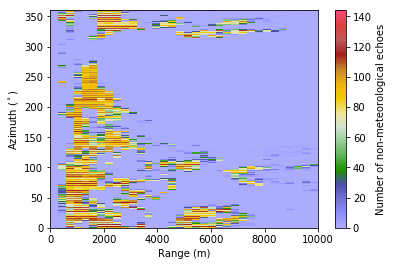

In [9]:
pl.figure()
pl.hist2d(range_tot, azi_tot, range=[[0, 10e3], [0, 360]], bins=(34, 360), cmap='pyart_Theodore16', vmin=0, vmax=len(flist))
pl.xlabel("Range (m)")
pl.ylabel("Azimuth $(^\circ)$")
c0 = pl.colorbar()
c0.set_label("Number of non-meteorological echoes")
pl.show()

In [13]:
# Need to send radar range and azimuth to function.
radar = pyart.io.read(flist[0])
rslice = radar.get_slice(0)
rrange = radar.range['data'].astype(int)
azimuth = radar.azimuth['data'][rslice]
nbfile = len(flist)

# Compute frequency map
clutter_r, clutter_azi, freq = compute_frequency_map(rrange, azimuth, range_tot, azi_tot, nbfile)
# We can save clutter_r, and clutter_azi for RCA use.

From that position we can save the arrays `clutter_r`, and `clutter_azi` into a data file for the second part of the RCA code.

In [15]:
freq = np.ma.masked_where(freq == 0, freq)

r = rrange
aziclut = np.linspace(0, 360, freq.shape[0], endpoint=False)
theta = azi2angl(aziclut)

[TH, R] = np.meshgrid(theta, r, indexing='ij')
x = R*np.cos(TH*np.pi/180)
y = R*np.sin(TH*np.pi/180)

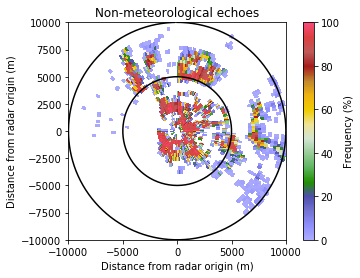

In [16]:
pl.figure()
pl.pcolor(x, y, freq, cmap='pyart_Theodore16', vmin=0, vmax=100)
for r in [5e3, 10e3]:
    pl.plot(r*np.cos(theta*np.pi/180), r*np.sin(theta*np.pi/180), 'k-')
    
pl.axis('square')
pl.axis((-10e3, 10e3, -10e3, 10e3))
pl.title("Non-meteorological echoes")
pl.xlabel("Distance from radar origin (m)")
pl.ylabel("Distance from radar origin (m)")
c0 = pl.colorbar()
c0.set_label("Frequency (%)")
pl.show()

# Part 2: Computing the radar monitoring value

In [17]:
def compute_95th_percentile(the_data):
    """
    Compute the 95th percentile.

    Parameter:
    ==========
        the_data: np.array
            The clutter data.

    Returns:
    ========
        to_return: float
            95th percentile of the input data.
    """

    clut_series = pd.Series(the_data[~np.isnan(the_data)])
    to_return = clut_series.quantile(0.95)

    return to_return

In [18]:
def extract_clutter(radar, r_mask, th_mask, dbz_name='DBZ'):
    """
    Extract reflectivity data that has the same (r, azi) as the clutter mask.

    Parameters:
    ===========
        radar: struct
            Py-ART radar structure.
        r_mask: numpy.array(float)
            Clutter range.
        th_mask: numpy.array(float)
            Clutter azimuth.
        dbz_name: str
            Reflectivity field name.

    Returns:
    ========
        clut: numpy.array(float)
            Extracted clutter reflectivity.
    """
    # Extract first elevation only
    rslice = radar.get_slice(0)
    # Extract range/azimuth
    r = radar.range['data'].astype(int)
    azi = radar.azimuth['data'][rslice]
    # Angle variation tolerance
    dazi = 0.5
    
    # Get reflectivity and RHOHV
    reflec = radar.fields[dbz_name]['data'][rslice].filled(np.NaN)
    dr = r[1] - r[0]    
    clut = []

    for the_r, the_azi in zip(r_mask, th_mask):
        pos_r = np.where((the_r >= r-dr) & (the_r < r + dr))[0]
        pos_azi = np.where((azi >= the_azi - dazi) &
                           (azi < the_azi + dazi))[0]

        if (len(pos_r) > 0) & (len(pos_azi) > 0):  # Non-empty array
            if len(pos_r) == len(pos_azi):
                rtmp = pos_r
                ttmp = pos_azi
            else:
                rtmp = pos_r[0]
                ttmp = pos_azi[0]
        else:
            continue

        try:
            value_rca = reflec[ttmp, rtmp]
            if np.isscalar(value_rca):
                clut.append(value_rca)
            elif len(value_rca) >= 1:
                [clut.append(tmp_value) for tmp_value in value_rca]
            else:
                continue
        except IndexError as err:
            print("Could not apply clutter mask.")
            traceback.print_exc()
            continue
    
    return np.array(clut)

In [33]:
def multproc_buffer_rca(infile, range_permanent_echoes, azi_permanent_echoes):
    """
    Buffer function for multiprocessing and handleing errors.    
    """
    try:
        radar = pyart.io.read(infile)
#         print("{} read.".format(os.path.basename(infile)))
    except Exception:
        print("Could not read input file", os.path.basename(infile))
        return None
    
    volume_date = num2date(radar.time['data'][0], radar.time['units'])
    
    try:
        ext_clut = extract_clutter(radar, range_permanent_echoes, azi_permanent_echoes)
    except Exception:
        print("Problem with this file:", os.path.basename(infile))
        traceback.print_exc()
        return None
    
    rca = compute_95th_percentile(ext_clut)
    
    return volume_date, rca

`clutter_r`, and `clutter_azi` have been created in part 1.

In [63]:
# We created the mask on one day, that is enough, now we want to monitor 10 days of our dataset
flist2 = glob.glob("/g/data2/rr5/vhl548/CPOL_level_1/2006/2006010*/*.nc")

In [64]:
# Create argument list for multiprocessing
args_list = []
for fd in flist2:
    tmp = (fd, clutter_r, clutter_azi)
    args_list.append(tmp)

In [65]:
with Pool(8) as pool:
    rslt = pool.starmap(multproc_buffer_rca, args_list)

In [66]:
# Unpack rslt
rca = []
xdate = []
for tmptime, tmprca in rslt:
    xdate.append(tmptime)
    rca.append(tmprca)

rca = np.array(rca)
xdate = np.array(xdate, dtype='datetime64[s]')
pos = np.argsort(xdate)
xdate = xdate[pos]
rca = rca[pos]

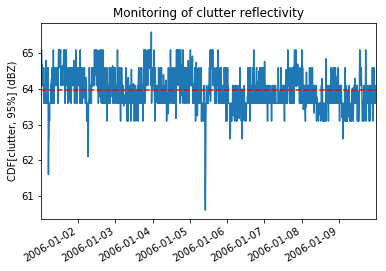

In [67]:
fig = pl.figure()
pl.plot(xdate, rca)
pl.plot([xdate.min(), xdate.max()], [rca.mean(), rca.mean()], 'r--')
pl.xlim([xdate.min(), xdate.max()])
pl.title("Monitoring of clutter reflectivity")
pl.ylabel("CDF[clutter, 95%] (dBZ)")
fig.autofmt_xdate()
pl.show()

In [68]:
rca.mean()

63.964024353027348

In [69]:
rca.std()

0.52086507864273701